<a href="https://colab.research.google.com/github/SiLiKhon/HEPStatsSeminar/blob/Artem-Seminar2-tests/seminar2/LinearModels_ToyData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear models

## Linear regression

For a set of inputs
$$({\bf x}_i, y_i),$$
$${\bf x}_i\in \mathbb{R}^M,$$
$$y_i\in \mathbb{R}^1,$$
$$i=1,\ldots,N$$
we are looking for a function of the form
$$f({\bf x}) = {\bf W}\cdot{\bf x} + b,$$
$${\bf W}\in \mathbb{R}^M,$$
$$b\in \mathbb{R}^1$$
such that
$$\sum_{i=1}^N(y_i - f({\bf x}_i))^2$$
is minimal.

Let's do our regular imports:

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

We are going to use a linear regression model to fit a 3rd order polynomial.

In [0]:
nx = 15 # number of points
np.random.seed(42) # to reproduce the same random state
x = np.sort(np.random.uniform(-2., 2., size=nx))
y = x**3 - 1.5 * x**2 - 2. * x - 1
y += np.random.normal(scale=0.7, size=nx) # adding some noize to the data

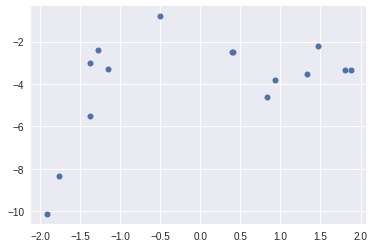

In [18]:
plt.plot(x, y, 'o', markersize=6);

We will use the scikit-learn library (https://scikit-learn.org/). Let's import its `linear_model` module:

In [0]:
from sklearn import linear_model

`sklearn` models expect that our input to be of shape `(n_samples, n_features)`. So far we have only one single feature, so we have to reshape our input to `(n_samples, 1)`. Let's write a function for that:

In [5]:
def features(x):
  return x.reshape((-1, 1))

print(features(x).shape)

(15, 1)


Ok, now it's time to build and train the model:

In [6]:
model = linear_model.LinearRegression()
model.fit(features(x), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Let's write a function to plot the results:

In [0]:
def plot_model(model, features):
  pred_x = np.linspace(-2, 2, 200)
  pred_y = model.predict(features(pred_x))

  plt.plot(x, y, 'o', markersize=6);
  plt.plot(pred_x, pred_y);

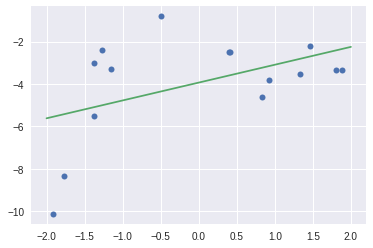

In [8]:
plot_model(model, features)

Obviously, linear model can't fit a non-linear dependency. Or can it?

Can you think of a modification to the inputs such that our model turns to a higher degree polynomial fit?

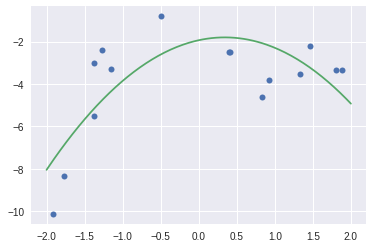

In [19]:
def features(x):
  return np.stack([x, x**2]).T

model = linear_model.LinearRegression()
model.fit(features(x), y)

plot_model(model, features)

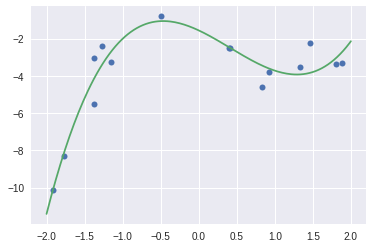

In [20]:
def features(x):
  return np.stack([x, x**2, x**3]).T

model = linear_model.LinearRegression()
model.fit(features(x), y)

plot_model(model, features)

3rd order polynomial fit looks good! Can we go higher?

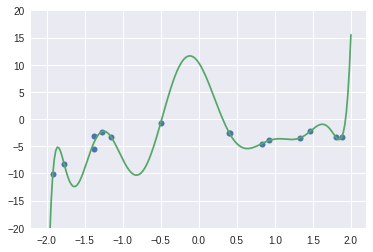

In [21]:
def features(x):
  return np.stack([x**n for n in range(1, 12)]).T

model = linear_model.LinearRegression()
model.fit(features(x), y)

plot_model(model, features)
plt.ylim(-20, 20);

Hmm, is this fit better? It certainly goes closer to the input points...  Let's test its predictive power:

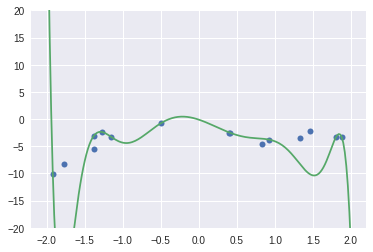

In [22]:
np.random.seed(42)
selection = np.random.binomial(1, 0.7, len(x)).astype(bool)

model = linear_model.LinearRegression()
model.fit(features(x[selection]), y[selection])

plot_model(model, features)
plt.ylim(-20, 20);

So it doesn't describe the points it has never seen. This is called **overfitting**.

## k-fold cross-validation

This is a common validation method:
  - split the dataset $D$ to $k$ parts: $D_i$, $i=1,\ldots,k$
  - for each $i=1,\ldots,k$ do the following:
    - fit the model on $D \setminus D_i$ (on all elements from $D$ that are not in $D_i$)
    - evaluate model performance on $D_i$: obtain score $l_i$
  - calculate the average score $l=\frac{1}{k}\sum_{i=1}^kl_i$ of the model's performance.

Let's assume we don't know the nature of our input data and we want to select the best model. We can use k-fold cross-validation method to evaluate our model for each polynomial order.

Scikit-learn has the `model_selection` module with k-fold x-validation functionality implemented.

In [0]:
from sklearn import model_selection


# defining our score function (root mean square loss - the smaller the better)
def rms_loss(y_true, y_pred):
  return ((y_true - y_pred)**2).mean()**0.5


# train and evaluate the model on a single split
def single_eval(x_train, y_train, x_test, y_test, features):
  model = linear_model.LinearRegression()
  model.fit(features(x_train), y_train)
  return rms_loss(y_test, model.predict(features(x_test)))


# run the k-fold x-validation loop and return the array of losses
def test_model(model, features, n_splits=5):
  kf = model_selection.KFold(n_splits=n_splits)
  rms = []
  for i_train, i_test in kf.split(x):
    rms.append(single_eval(x[i_train], y[i_train], x[i_test], y[i_test], features))
  return np.array(rms)

In [0]:
rms_vs_power = np.array([
    (i, test_model(
          model,
          lambda x: np.stack([x**n for n in range(1, i + 1)]).T
    ).mean()) for i in range(1, 14)
]).T

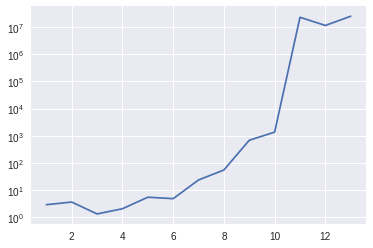

In [25]:
plt.plot(rms_vs_power[0], rms_vs_power[1]);
plt.yscale('log')

## Logistic regression

Binary classification:
$$y_i\in\left\{0; 1\right\}$$

Model:
$$P(y=1|{\bf x}, {\bf W}) = \sigma({\bf W}\cdot{\bf x}),$$
where $\sigma$ is the *sigmoid* function:
$$\sigma(a) = \frac{1}{1 + e^{-a}}$$



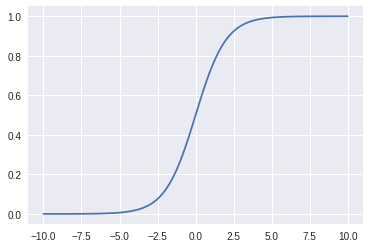

In [83]:
def sigmoid(x):
  return 1. / (1. + np.exp(-x))

x = np.linspace(-10, 10, 100)
plt.plot(x, sigmoid(x));

This model is implemented in scikit-learn with the following default loss (cross-entropy):
$$L({\bf W})=-\sum_i\left(
y_i\, log P(y=1|{\bf x}_i, {\bf W})
+
(1-y_i)logP(y=0|{\bf x}_i, {\bf W})
\right)$$
plus a regularization term $\frac{1}{2}{\bf W}\cdot{\bf W}$.

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Let's try to separate two rectangular clusters with it.

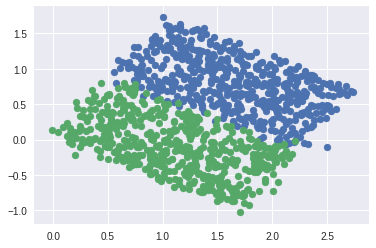

In [109]:
N0 = 512
N1 = 512

X0_ = np.random.uniform(size=(N0, 2)) * [[2, 1]] + np.random.normal(scale=0.05, size=(N0, 2)) + [[0, 1]]
X1_ = np.random.uniform(size=(N1, 2)) * [[2, 1]] + np.random.normal(scale=0.05, size=(N0, 2))


alpha = np.pi / 6.
rot = [[ np.cos(alpha), np.sin(alpha)],
       [-np.sin(alpha), np.cos(alpha)]]
X0 = np.matmul(rot, X0_.T).T
X1 = np.matmul(rot, X1_.T).T

y0 = np.zeros(shape=N0)
y1 = np.ones (shape=N1)

X = np.concatenate([X0, X1], axis=0)
y = np.concatenate([y0, y1], axis=0)
perm = np.random.permutation(len(y))
X = X[perm]
y = y[perm]

plt.scatter(*X[y==0].T);
plt.scatter(*X[y==1].T);

In [0]:
from sklearn import metrics

In [110]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

preds_train = model.predict_proba(X_train)[:,1]
preds_test  = model.predict_proba(X_test )[:,1]

print("train score: {}".format(metrics.roc_auc_score(y_train, preds_train)))
print("test score:  {}".format(metrics.roc_auc_score(y_test , preds_test )))

train score: 0.9987846856816962
test score:  0.9983965464076473


In [0]:
def visualize_model(
        model,
        grid0=np.linspace(-0.5, 3.0, 100),
        grid1=np.linspace(-1.5, 2.0, 100),
        feature_transform=lambda x: x
    ):
  x0, x1 = np.meshgrid(grid0, grid1)
  xx = np.stack([x0.flatten(), x1.flatten()], axis=1)
  y = model.predict_proba(feature_transform(xx))[:,1].reshape(x0.shape)
  plt.contourf(x0, x1, y, 100, cmap='seismic')

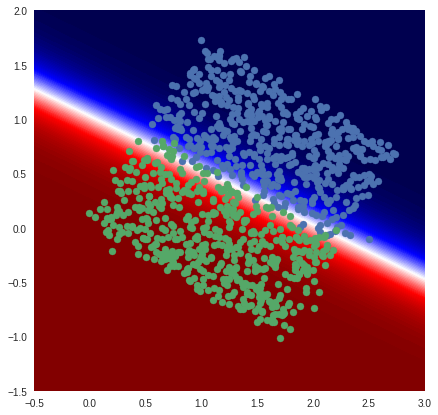

In [112]:
plt.figure(figsize=(7, 7))
visualize_model(model)
plt.scatter(*X[y==0].T);
plt.scatter(*X[y==1].T);

In [0]:
from sklearn import datasets

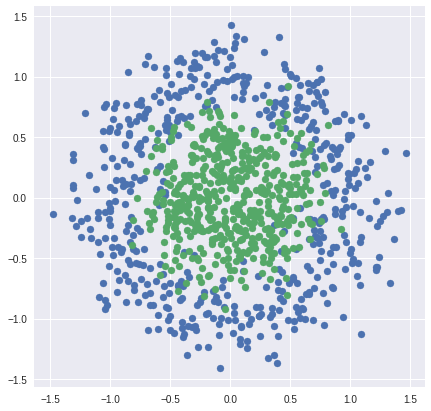

In [113]:
X, y = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
plt.figure(figsize=(7, 7))
plt.scatter(*X[y==0].T);
plt.scatter(*X[y==1].T);

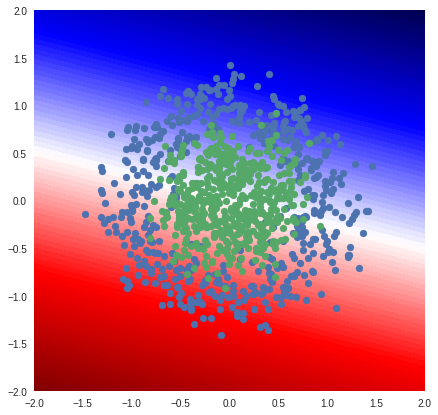

In [114]:
model = linear_model.LogisticRegression()
model.fit(X, y)

plt.figure(figsize=(7,7))
visualize_model(model,
                np.linspace(-2., 2., 100),
                np.linspace(-2., 2., 100));
plt.scatter(*X[y==0].T);
plt.scatter(*X[y==1].T);

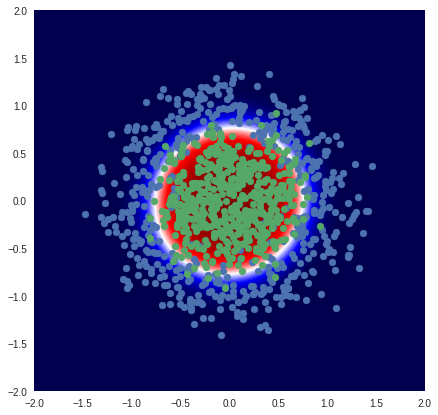

In [115]:
def features(xx):
  return np.stack([
      xx[:,0],
      xx[:,1],
      xx[:,0]**2,
      xx[:,1]**2,
      xx[:,0] * xx[:,1],
  ], axis=1)

model = linear_model.LogisticRegression()
model.fit(features(X), y)

plt.figure(figsize=(7,7))
visualize_model(model,
                np.linspace(-2., 2., 100),
                np.linspace(-2., 2., 100),
                features)
plt.scatter(*X[y==0].T);
plt.scatter(*X[y==1].T);

In [0]:
N=100

In [0]:
x0, y0 = np.random.normal(size=(2, N))
y0 *= 0.3
y0 += 5 * (-1)**np.random.randint(2, size=N)

In [0]:
phi = np.random.uniform(0, 2 * np.pi, size=N)
r   = 10 + np.random.normal(size=N)
x1, y1 = r * np.cos(phi), r * np.sin(phi) * 0.3
y1 += 5 * (-1)**np.random.randint(2, size=N)

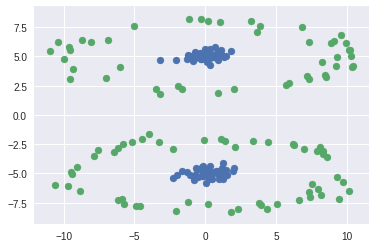

In [5]:
plt.scatter(x0, y0)
plt.scatter(x1, y1);

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [0]:
ds0 = pd.DataFrame({'x' : x0, 'y' : y0, 'class' : 0})
ds1 = pd.DataFrame({'x' : x1, 'y' : y1, 'class' : 1})

In [0]:
data = pd.concat([ds0, ds1], ignore_index=True)
data = data.iloc[np.random.permutation(len(data))].reset_index(drop=True).copy()

In [0]:
def features(ar):
  return np.array([
      np.ones(len(ar)),
      ar[:,0],
      ar[:,0]**2,
      ar[:,0]**3,
      ar[:,0]**4,
      ar[:,1],
      ar[:,1]**2,
      ar[:,1]**3,
      ar[:,1]**4,
      ar[:,0]    * ar[:,1],
      ar[:,0]**2 * ar[:,1],
      ar[:,0]    * ar[:,1]**2,
      ar[:,0]**2 * ar[:,1]**2,
      ar[:,0]**3 * ar[:,1],
      ar[:,0]    * ar[:,1]**3,
      ar[:,0]**2 * ar[:,1]**3,
      ar[:,0]**3 * ar[:,1]**2,
  ]).T

In [10]:
model = LogisticRegression(C=1.e30)
model.fit(features(data[['x', 'y']].values), data['class'])

LogisticRegression(C=1e+30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
x, y = np.meshgrid(np.linspace(-15, 15, 1000), 
                   np.linspace(-15, 15, 1000))
x, y = x.flatten(), y.flatten()
xy = np.stack([x, y]).T

In [0]:
preds_xy = model.predict_proba(features(xy))[:,1].reshape(1000, 1000)

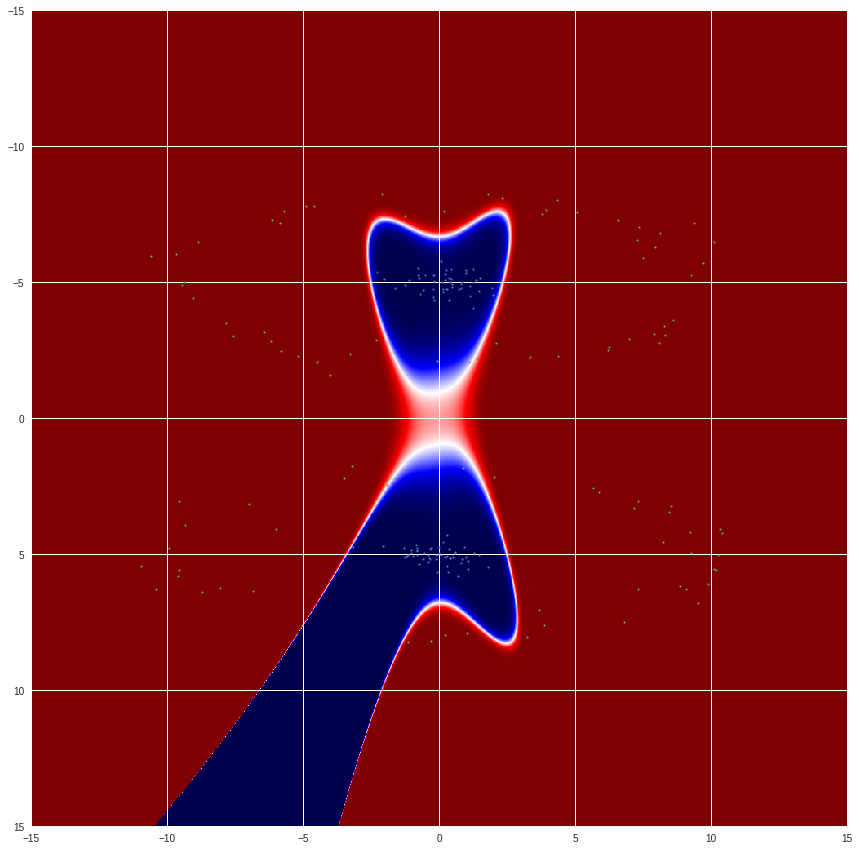

In [13]:
plt.figure(figsize=(15, 15))
plt.imshow(preds_xy, extent=(-15, 15, 15, -15), cmap='seismic')
plt.scatter(x0, y0, s=3)
plt.scatter(x1, y1, s=3);

In [221]:
roc_auc_score(data['class'], model.predict_proba(features(data[['x', 'y']].values))[:,1])

0.9999